In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

C:\Users\willo_jlqcl0r\AppData\Local\Temp\ipykernel_19868\433265922.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [42]:
train = pd.read_csv("CSI4810_projectVehicleData/preprocessedTrain.csv")
target = train.pop("loan_default")
test = pd.read_csv("CSI4810_projectVehicleData/preprocessedTest.csv")

---

### Create new features<br>



In [43]:
train['pri_no_sanct_amt_nonzero_disb_amt_flg'] = np.where((train['pri_disbursed_amount'] > 0) & (train['pri_sanctioned_amount'] == 0), 1, 0)
train = train.loc[~((train['sec_sanctioned_amount'] == 0) & (train['sec_disbursed_amount'] > 0))]
train['pri_percent_credit_used'] = ((train.loc[((train['pri_active_accts'] > 0) 
                                               & (train['pri_no_sanct_amt_nonzero_disb_amt_flg'] != 1))]
                                               ['pri_disbursed_amount']
                                                 / train.loc[((train['pri_active_accts'] > 0) 
                                                              & (train['pri_no_sanct_amt_nonzero_disb_amt_flg'] != 1))]
                                                              ['pri_sanctioned_amount']) * 100).fillna(-1)
train['pri_percent_credit_used'] = train['pri_percent_credit_used'].fillna(-1)
train['sec_percent_credit_used'] = ((train.loc[(train['sec_active_accts'] > 0) ]
                                               ['sec_disbursed_amount']
                                                 / train.loc[(train['sec_active_accts'] > 0)]
                                                              ['sec_sanctioned_amount']) * 100)
train['sec_percent_credit_used'] = train['sec_percent_credit_used'].fillna(-1)

---
### Preliminary Model testing

---

##### Outlier Handling Validation


In [5]:
preLogReg = LogisticRegression(class_weight='balanced',random_state=42,max_iter=500)
preTree = RandomForestClassifier(class_weight='balanced',random_state=42,max_depth=20)


<b>Outliers</b><br>
dropping entries that appear OOB

Note 1: We can see that dropping the top 5% of outliers for the specified columns doesn't have an effect on the logistic regression model, but for the random forest model, we can see a significant impact. Especially in how it classifies the minority class; it's performance drastically decreases. Tests were also run on the top 1% and the same effect was seen



In [6]:
target = target.loc[train.index]
X, Xtest, y, ytest = train_test_split(train, target, test_size=0.2, random_state=42)

In [7]:
# pre removal scores
normalizedX = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
normalizedXtest = pd.DataFrame(StandardScaler().fit_transform(Xtest), columns=Xtest.columns)
preLogReg.fit(normalizedX, y)
preTree.fit(normalizedX, y)
print("Validation Logreg\n", classification_report(ytest, preLogReg.predict(normalizedXtest)))
print("Validation Tree\n", classification_report(ytest, preTree.predict(normalizedXtest)))

Validation Logreg
               precision    recall  f1-score   support

           0       0.85      0.55      0.67     36612
           1       0.28      0.64      0.39     10019

    accuracy                           0.57     46631
   macro avg       0.56      0.60      0.53     46631
weighted avg       0.73      0.57      0.61     46631

Validation Tree
               precision    recall  f1-score   support

           0       0.81      0.82      0.82     36612
           1       0.31      0.29      0.30     10019

    accuracy                           0.71     46631
   macro avg       0.56      0.56      0.56     46631
weighted avg       0.70      0.71      0.71     46631



In [8]:
outlierList = ['disbursed_amount', 'asset_cost', 'pri_overdue_accts', 'pri_current_balance', 
               'pri_sanctioned_amount', 'pri_disbursed_amount', 'primary_instal_amt','sec_sanctioned_amount',
               'sec_current_balance','sec_disbursed_amount','sec_instal_amt']
def findIQR(col):
    return X[col].quantile(.99) + 1.5 * (X[col].quantile(.99) - X[col].quantile(.01))

for c in outlierList: 
    X = X.loc[~(X[c] > findIQR(c))]

In [ ]:
# post removal scores
y = y.loc[X.index]
normalizedX = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)
normalizedXtest = pd.DataFrame(StandardScaler().fit_transform(Xtest), columns=Xtest.columns)
preLogReg.fit(normalizedX,y)
print(normalizedX.shape)
preTree.fit(normalizedX,y)
print("Validation Logreg\n",classification_report(ytest,preLogReg.predict(normalizedXtest)))
print("Validation Tree\n",classification_report(ytest,preTree.predict(normalizedXtest)))

(181742, 37)
Validation Logreg
               precision    recall  f1-score   support

           0       0.85      0.56      0.67     36612
           1       0.28      0.64      0.39     10019

    accuracy                           0.57     46631
   macro avg       0.57      0.60      0.53     46631
weighted avg       0.73      0.57      0.61     46631

Validation Tree
               precision    recall  f1-score   support

           0       0.79      0.98      0.87     36612
           1       0.41      0.06      0.10     10019

    accuracy                           0.78     46631
   macro avg       0.60      0.52      0.49     46631
weighted avg       0.71      0.78      0.71     46631



---

<b>Errors</b><br>
dropping entries that appear erroneous - we can see 178 rows were dropped which corresponds to .076 % of the dataset.



since these outliers seem to have pretty important data for the second class, I will not remove most of them. This is becasue it appears that the Random Forest model performs better overall than the logistic regression model. 

However, I will remove a hand selected few entries that appear erroneous or are severely out of bounds. 


we can see that the 75th percentile has a credit utilization percentage of 107% but the max percentage is in the order of millions. This percentage is not realistically possible. Taking a furhter look into the data we find there are several entries with a credit utilization ratio over 1000%, again, this is unrealistic and could possibly be outliers or more possibly, erroneous entries. To reduce noise in the dataset, the entries over a 200% credit utilization ratio will be removed. This is 159 entries. This allows us to preserve the data of those who use more credit than given while removing the outliers and erroneous entries, thus, reducing noise.

In [9]:
X, Xtest, y, ytest = train_test_split(train, target, test_size=0.2, random_state=42)

In [10]:
print(X['pri_percent_credit_used'].describe())
print("\nnumber of rows above 200%",X.loc[(X['pri_percent_credit_used'] > 200)].shape)
X.drop(index=X[X['pri_percent_credit_used'] > 200].index,inplace=True,axis=0)
X = X.loc[~(X['pri_disbursed_amount'] >= 1000000000)]

count    1.865210e+05
mean     4.242070e+03
std      1.814272e+06
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%      1.000000e+02
max      7.835491e+08
Name: pri_percent_credit_used, dtype: float64

number of rows above 200% (135, 36)


In [ ]:
# post error removal scores
y = y.loc[X.index]
normalizedX = pd.DataFrame(StandardScaler().fit_transform(X) , columns=X.columns)
normalizedXtest = pd.DataFrame(StandardScaler().fit_transform(Xtest) , columns=Xtest.columns)
preLogReg.fit(normalizedX,y)
print(normalizedX.shape)
preTree.fit(normalizedX,y)
print("Validation Logreg\n",classification_report(ytest,preLogReg.predict(normalizedXtest)))
print("Validation Tree\n",classification_report(ytest,preTree.predict(normalizedXtest)))

(186521, 36)
Validation Logreg
               precision    recall  f1-score   support

           0       0.85      0.55      0.67     36612
           1       0.28      0.64      0.39     10019

    accuracy                           0.57     46631
   macro avg       0.56      0.60      0.53     46631
weighted avg       0.73      0.57      0.61     46631

Validation Tree
               precision    recall  f1-score   support

           0       0.81      0.82      0.82     36612
           1       0.31      0.29      0.30     10019

    accuracy                           0.71     46631
   macro avg       0.56      0.56      0.56     46631
weighted avg       0.70      0.71      0.71     46631



In [44]:
train.drop(index=train[train['pri_percent_credit_used'] > 200].index,inplace=True,axis=0)
train = train.loc[~(train['pri_disbursed_amount'] >= 1000000000)]
train.shape

(232992, 36)

---

### Feature Importance & Selection<br>


NOTE: current_pincode_id is also a categorical feature; however, it s such a high score in the chi2 square that all other entries were rendered obsolete. This feature will be included in the final feature subset as location information is definitely a factor in determining vehicle loan default




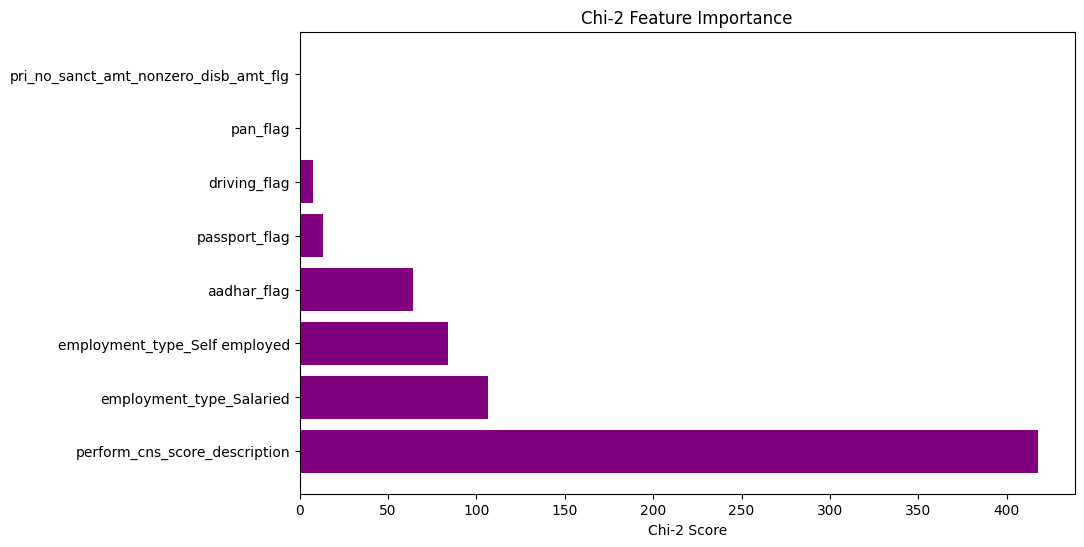

In [45]:
target = target.loc[train.index]

x=['aadhar_flag','pan_flag','employment_type_Self employed',
   'driving_flag','passport_flag','perform_cns_score_description',
   'pri_no_sanct_amt_nonzero_disb_amt_flg','employment_type_Salaried']

chiScores, pVals = chi2(train.loc[:,x], target)

chi2_df = pd.DataFrame({
    'col': train.loc[:,x].columns,
    'Chi2 Score': chiScores,
    'P-Value': pVals
}).sort_values(by='Chi2 Score',ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(chi2_df['col'], chi2_df['Chi2 Score'], color='purple')
plt.xlabel('Chi-2 Score')
plt.title('Chi-2 Feature Importance')
plt.show()

In [46]:
train = train.drop(['passport_flag', 'driving_flag', 'aadhar_flag', 
                    'pri_no_sanct_amt_nonzero_disb_amt_flg','pan_flag',
                    ],axis=1)

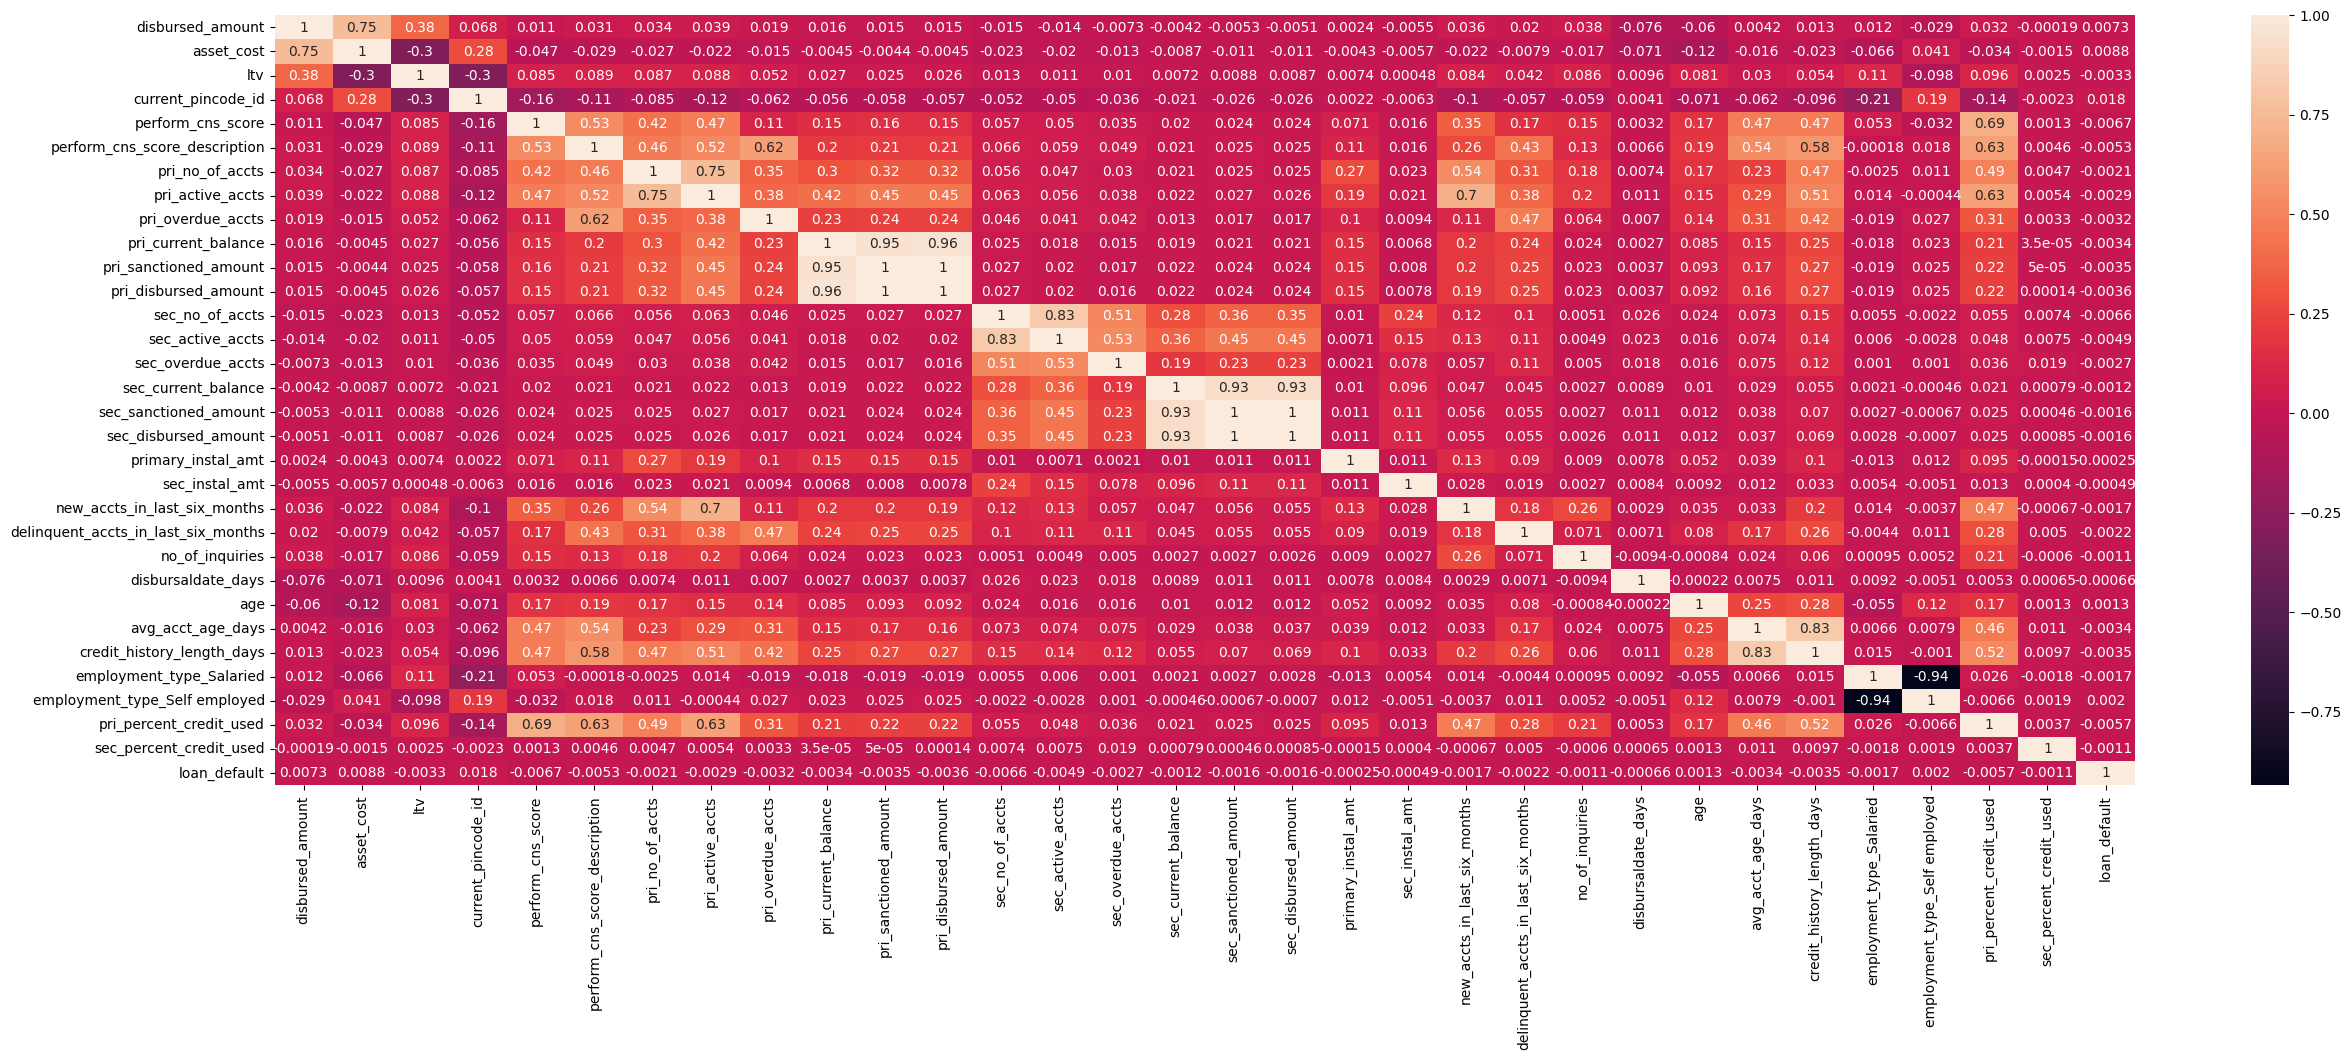

In [14]:
normalizedTrain = pd.DataFrame(StandardScaler().fit_transform(train) , columns=train.columns)
plt.figure(figsize=(30, 10))
sns.heatmap(pd.concat([normalizedTrain, target], axis=1).corr(), annot=True)
plt.show()

In [47]:
train = train.drop(['sec_disbursed_amount','pri_disbursed_amount',
                    'disbursed_amount','pri_no_of_accts', 'employment_type_Self employed',
                    'sec_sanctioned_amount','sec_no_of_accts',
                    ],axis=1)

---

### Feature Subset Selection

---

In [48]:
target = target.loc[train.index]
normalizedTrain = pd.DataFrame(StandardScaler().fit_transform(train), columns=train.columns)
X, Xtest, y, ytest = train_test_split(normalizedTrain, target, test_size=0.2, random_state=42)

In [33]:
sfm = SelectFromModel(preLogReg)
sfm.fit(X,y)
print(len(sfm.get_feature_names_out()))
sfm.get_feature_names_out()

9


array(['asset_cost', 'ltv', 'current_pincode_id', 'perform_cns_score',
       'perform_cns_score_description', 'pri_active_accts',
       'pri_sanctioned_amount', 'no_of_inquiries',
       'credit_history_length_days'], dtype=object)

In [34]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
pd.DataFrame(lda.coef_[0], lda.feature_names_in_).sort_values(ascending=False, by=[0])

,0
ltv,0.317674
perform_cns_score_description,0.213250
no_of_inquiries,0.111706
current_pincode_id,0.104538
asset_cost,0.085386
delinquent_accts_in_last_six_months,0.077925
avg_acct_age_days,0.069885
pri_overdue_accts,0.039550
pri_percent_credit_used,0.021885
sec_overdue_accts,0.002970


In [19]:
preTree.fit(X,y)
pd.DataFrame(preTree.feature_importances_, preTree.feature_names_in_).sort_values(ascending=False, by=[0])

,0
ltv,0.145957
current_pincode_id,0.126785
asset_cost,0.110326
disbursaldate_days,0.088187
age,0.078381
perform_cns_score,0.061067
pri_sanctioned_amount,0.057020
pri_current_balance,0.054019
credit_history_length_days,0.052702
primary_instal_amt,0.047769


In [49]:
train=train.drop(['perform_cns_score','pri_sanctioned_amount','avg_acct_age_days'],axis=1)

---
### Repeat for Test data

In [50]:
test['pri_no_sanct_amt_nonzero_disb_amt_flg'] = np.where((test['pri_disbursed_amount'] > 0) & (test['pri_sanctioned_amount'] == 0), 1, 0)
test = test.loc[~((test['sec_sanctioned_amount'] == 0) & (test['sec_disbursed_amount'] > 0))]
test['pri_percent_credit_used'] = ((test.loc[((test['pri_active_accts'] > 0) 
                                               & (test['pri_no_sanct_amt_nonzero_disb_amt_flg'] != 1))]
                                               ['pri_disbursed_amount']
                                                 / test.loc[((test['pri_active_accts'] > 0) 
                                                              & (test['pri_no_sanct_amt_nonzero_disb_amt_flg'] != 1))]
                                                              ['pri_sanctioned_amount']) * 100).fillna(-1)
test['pri_percent_credit_used'] = test['pri_percent_credit_used'].fillna(-1)
test['sec_percent_credit_used'] = ((test.loc[(test['sec_active_accts'] > 0) ]
                                               ['sec_disbursed_amount']
                                                 / test.loc[(test['sec_active_accts'] > 0)]
                                                              ['sec_sanctioned_amount']) * 100)
test['sec_percent_credit_used'] = test['sec_percent_credit_used'].fillna(-1)

In [51]:
print("\nnumber of rows above 200%",test.loc[(test['pri_percent_credit_used'] > 200)].shape)
print("\nnumber of rows above 1000000000 for disbursed amount",test.loc[(test['pri_disbursed_amount'] >= 1000000000)].shape)
# test.drop(index=test[test['pri_percent_credit_used'] > 200].index,inplace=True,axis=0)


number of rows above 200% (131, 37)

number of rows above 1000000000 for disbursed amount (0, 37)


In [52]:
test = test.drop(['passport_flag', 'driving_flag', 'aadhar_flag', 
                    'pri_no_sanct_amt_nonzero_disb_amt_flg','pan_flag',
                    'employment_type_Self employed','sec_disbursed_amount',
                    'pri_disbursed_amount','disbursed_amount','pri_no_of_accts',
                    'sec_sanctioned_amount','sec_no_of_accts','perform_cns_score',
                    'pri_sanctioned_amount','avg_acct_age_days'],axis=1)

---
### Output feature selected datasets

In [53]:
target = target.loc[train.index]
pd.concat([train, target], axis=1).to_csv("CSI4810_projectVehicleData/slectedFeaturesTrain.csv", index=False)
test.to_csv("slectedFeaturesTest.csv", index=False)